In [89]:
import os,sys
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import glob as glob
import numpy as np
import warnings
from scipy.stats import ttest_ind,f_oneway

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from plot_functions import plot_count, plot_box, plot_box_category, plot_regplot, barplot_count_multicat, barplot_pct_multicat

%reload_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings(action='once')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
os.getcwd()

'E:\\Projects\\ZS_Hackerrank_Feb2020'

In [55]:
os.chdir("..")

In [3]:
data_path = os.path.join(os.getcwd(),"Animal State Prediction - dataset")
os.chdir(data_path)
print(data_path)

E:\Projects\ZS_Hackerrank_Feb2020\Animal State Prediction - dataset


In [8]:
train_df = pd.read_csv("train.csv")
train_df.head()
# train_df["intake_datetime"] = pd.to_datetime("intake_datetime")
# train_df["date_of_birth"] = pd.to_datetime("date_of_birth")
# train_df["outcome_datetime"] = pd.to_datetime("outcome_datetime")

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 37 columns):
animal_id_outcome             47803 non-null object
dob_year                      47803 non-null int64
dob_month                     47803 non-null int64
age_upon_intake               47803 non-null object
animal_type                   47803 non-null object
breed                         47803 non-null object
color                         47803 non-null object
intake_condition              47803 non-null object
intake_type                   47803 non-null object
sex_upon_intake               47802 non-null object
count                         47803 non-null int64
age_upon_intake_(days)        47803 non-null int64
age_upon_intake_(years)       47803 non-null float64
age_upon_intake_age_group     47803 non-null object
intake_datetime               47803 non-null object
intake_month                  47803 non-null int64
intake_year                   47803 non-null int64
intake_month

**Note: dob_year,dob_month,age_upon_intake: can be ignored for now as we have age_upon_intake(days,years)**

## How many categories for each of the categorical columns?

In [19]:
train_df[["animal_type","age_upon_intake","age_upon_intake_age_group","breed","color","intake_condition","intake_type" \
                 ,"sex_upon_intake","intake_month","intake_year","intake_weekday","intake_hour","age_upon_outcome",\
          "sex_upon_outcome","age_upon_outcome_age_group","outcome_month","outcome_year","outcome_weekday","outcome_type"]].nunique()

animal_type                      4
age_upon_intake                 45
age_upon_intake_age_group        9
breed                         1847
color                          443
intake_condition                 8
intake_type                      5
sex_upon_intake                  5
intake_month                    12
intake_year                      6
intake_weekday                   7
intake_hour                     24
age_upon_outcome                45
sex_upon_outcome                 5
age_upon_outcome_age_group       9
outcome_month                   12
outcome_year                     6
outcome_weekday                  7
outcome_type                     9
dtype: int64

## Drop Empty column "outcome_datetime"

In [113]:
train_df.drop("outcome_datetime",axis=1,inplace=True)
train_df.dropna(how="any",inplace=True)
train_df.shape

(47802, 36)

## Bar charts exploration

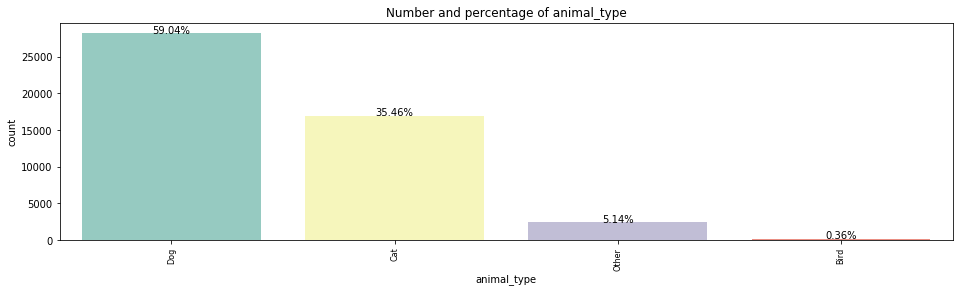

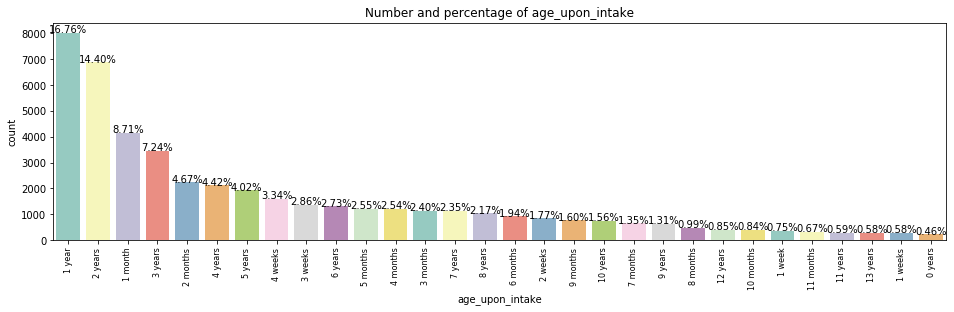

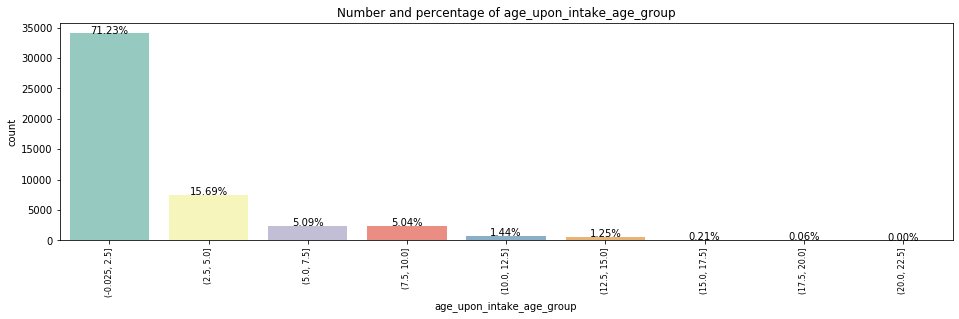

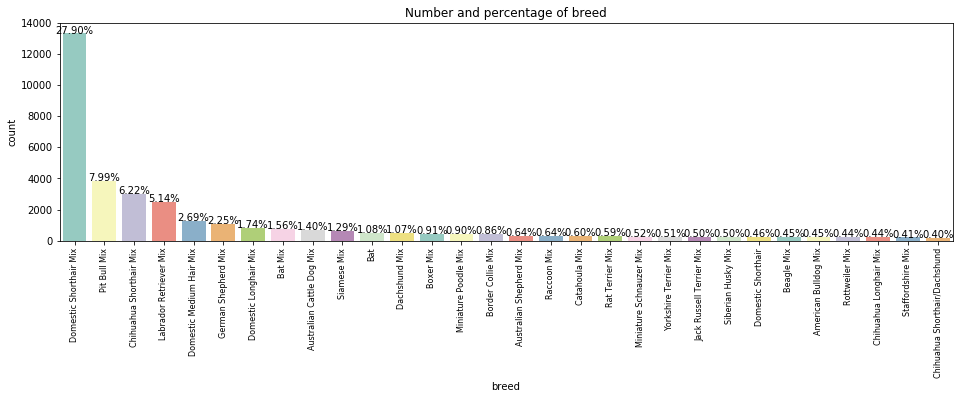

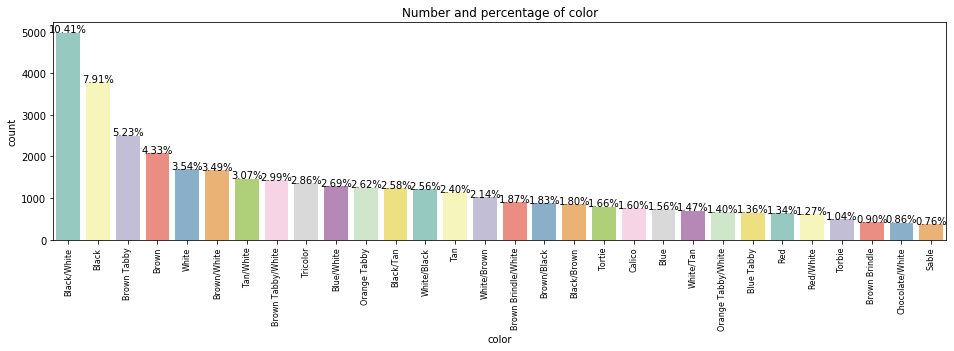

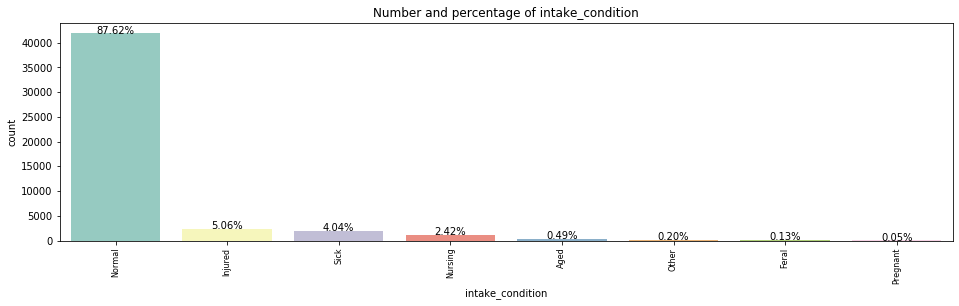

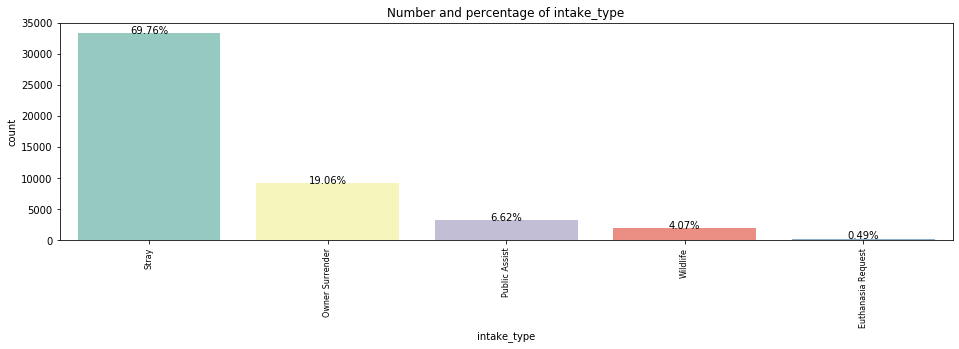

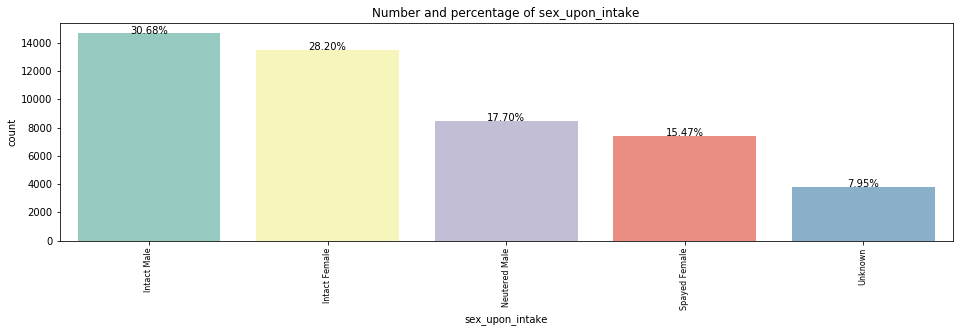

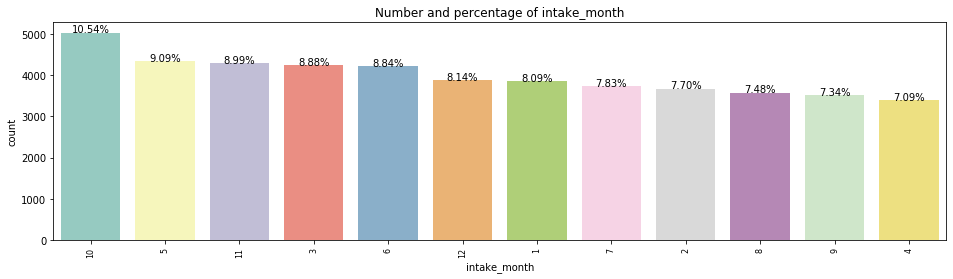

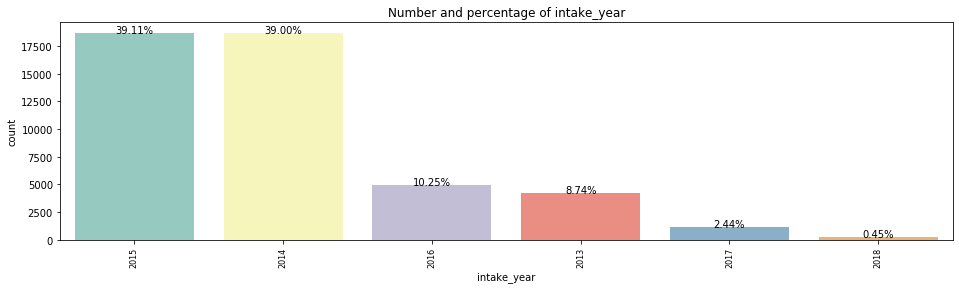

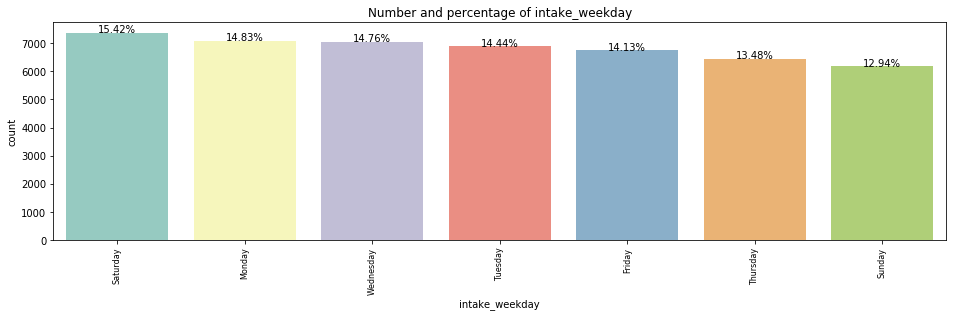

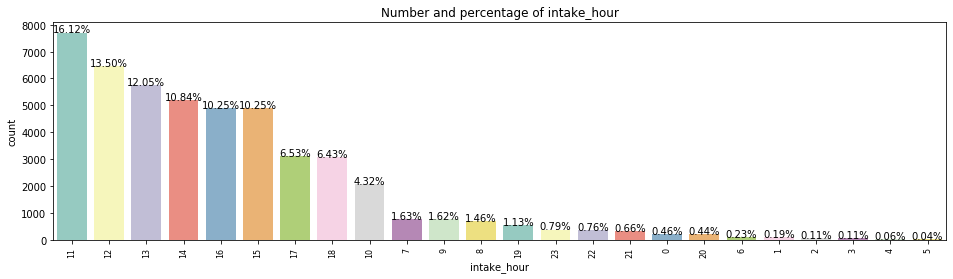

In [50]:
plot_cat_cols = ["animal_type","age_upon_intake","age_upon_intake_age_group","breed","color","intake_condition","intake_type" \
                 ,"sex_upon_intake","intake_month","intake_year","intake_weekday","intake_hour"]
for col in plot_cat_cols:
    plot_count(col,col,train_df,4)

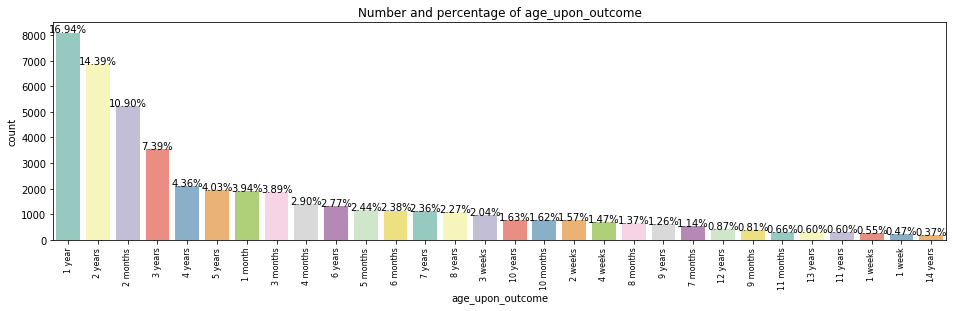

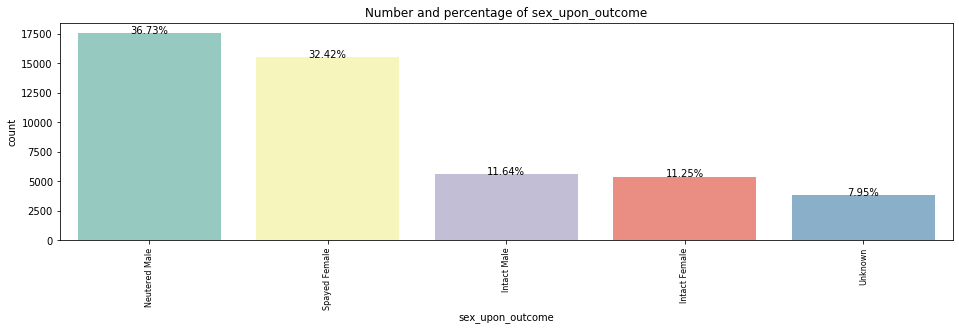

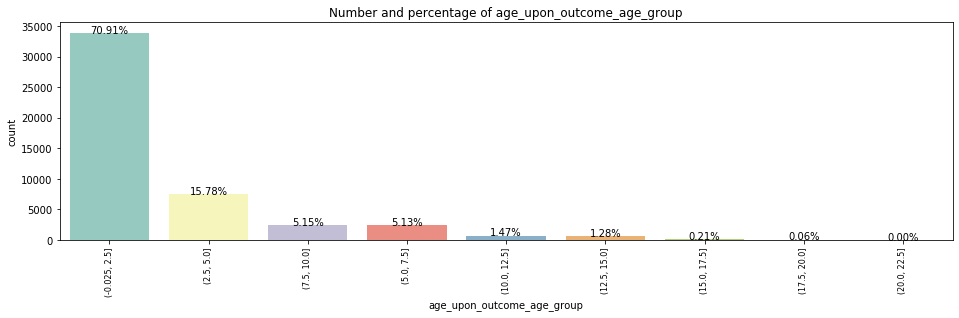

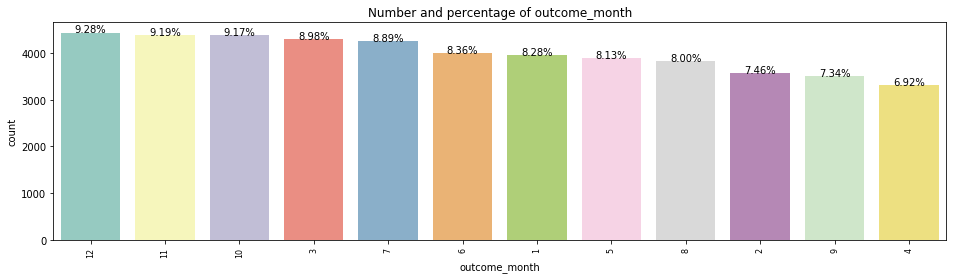

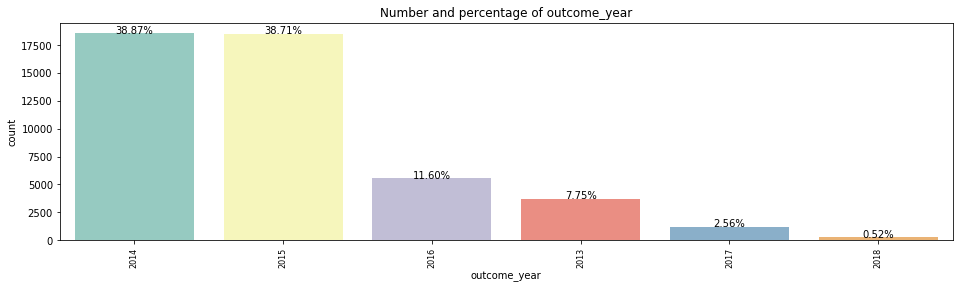

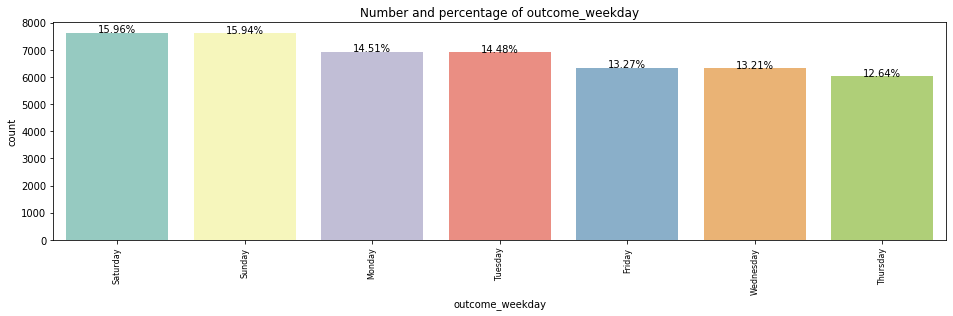

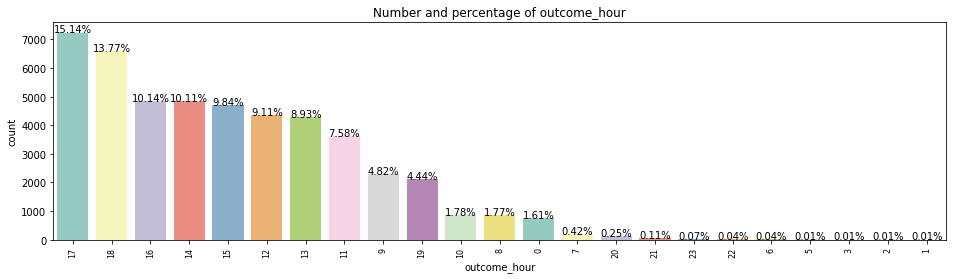

In [49]:
plot_cat_cols = ["age_upon_outcome","sex_upon_outcome","age_upon_outcome_age_group","outcome_month",\
                 "outcome_year","outcome_weekday","outcome_hour"]
for col in plot_cat_cols:
    plot_count(col,col,train_df,4)

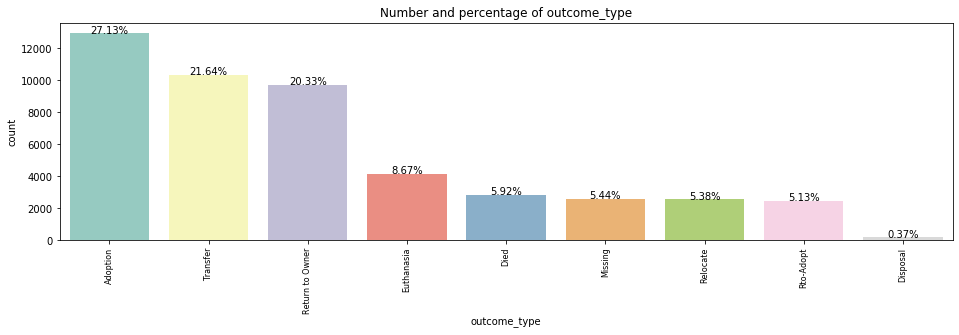

In [117]:
col = "outcome_type"
plot_count(col,col,train_df,4)

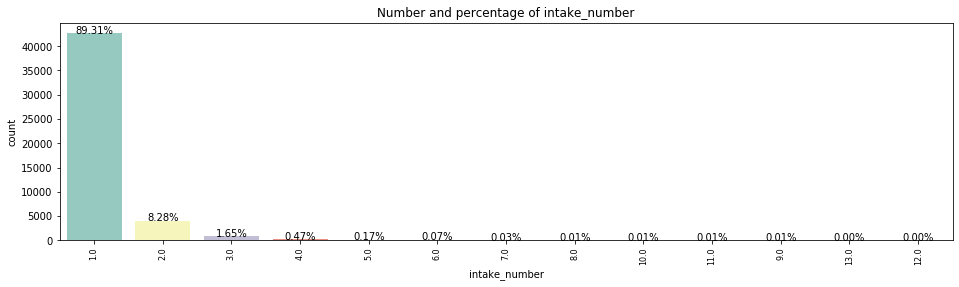

In [118]:
col = "intake_number"
plot_count(col,col,train_df,4)

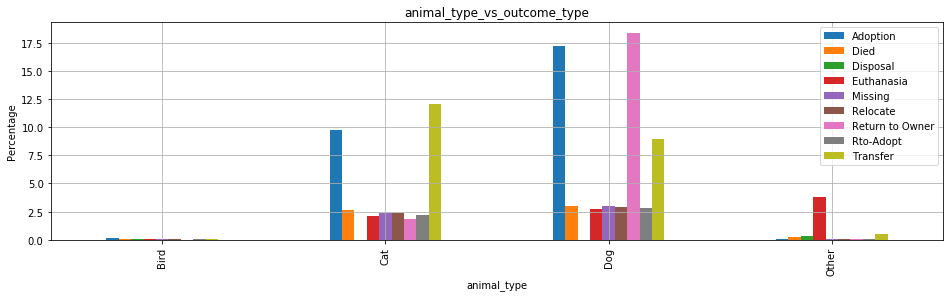

In [94]:
barplot_pct_multicat(["animal_type","outcome_type"],train_df,4)

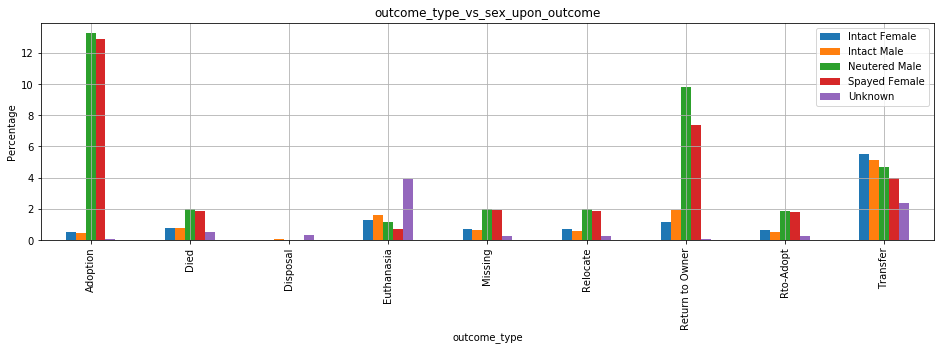

In [98]:
barplot_pct_multicat(["outcome_type","sex_upon_outcome"],train_df,4)

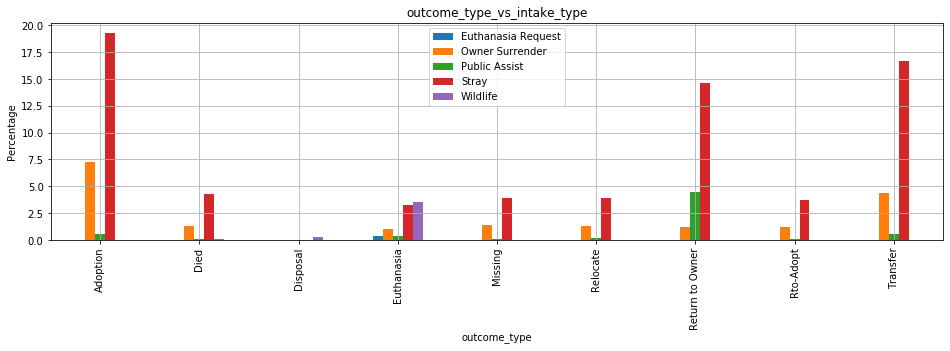

In [99]:
barplot_pct_multicat(["outcome_type","intake_type"],train_df,4)

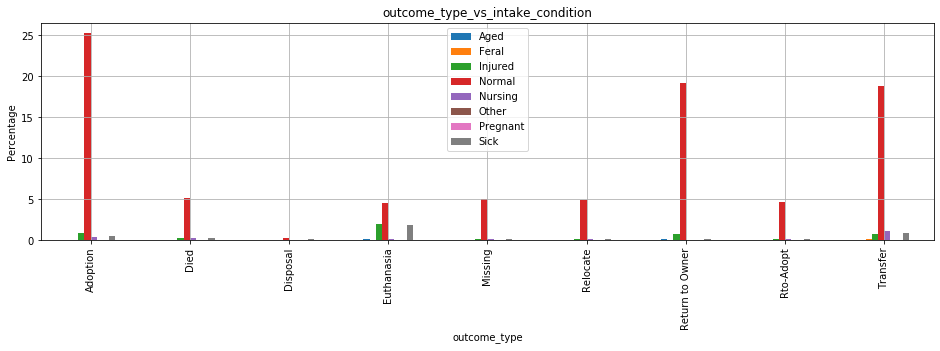

In [103]:
barplot_pct_multicat(["outcome_type","intake_condition"],train_df,4)

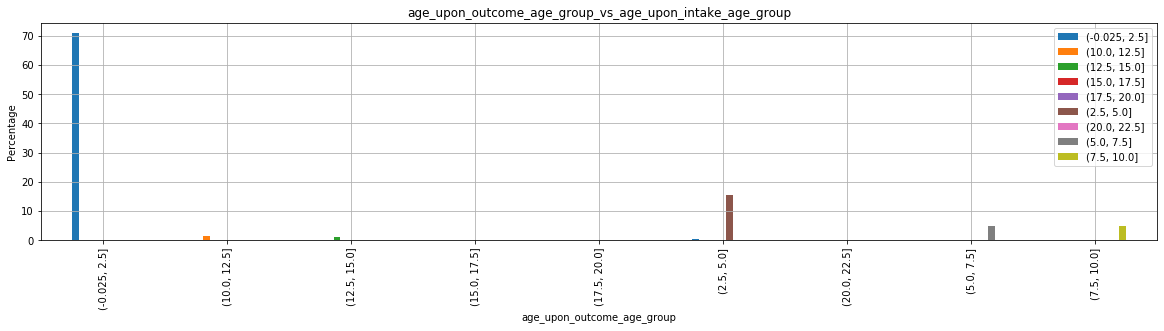

In [104]:
barplot_pct_multicat(["age_upon_outcome_age_group","age_upon_intake_age_group"],train_df,5)

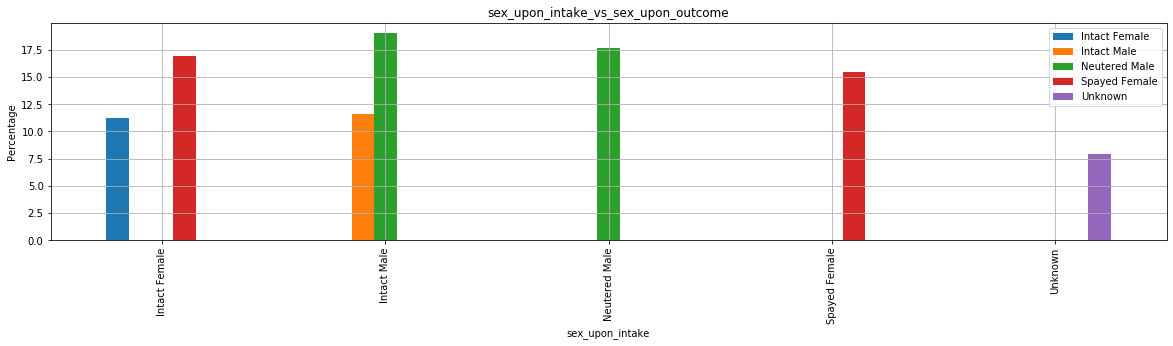

In [105]:
barplot_pct_multicat(["sex_upon_intake","sex_upon_outcome"],train_df,5)

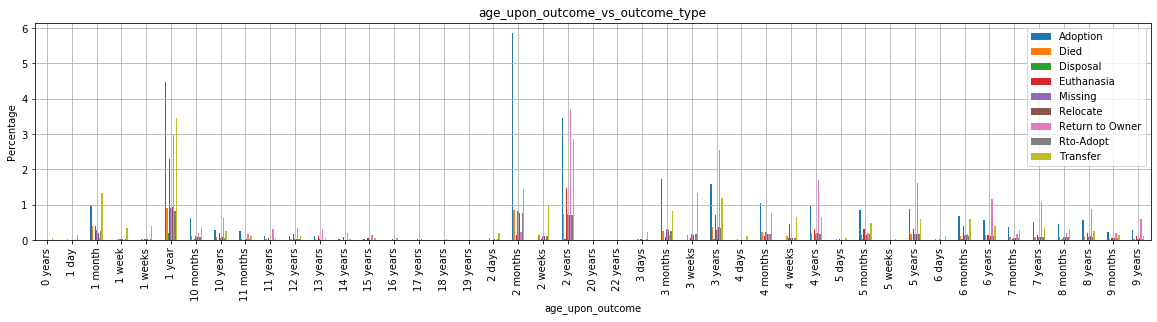

In [102]:
barplot_pct_multicat(["age_upon_outcome","outcome_type"],train_df,5)

## Box Plot exploration

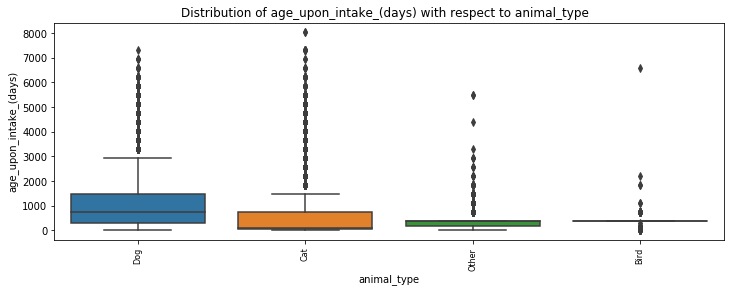

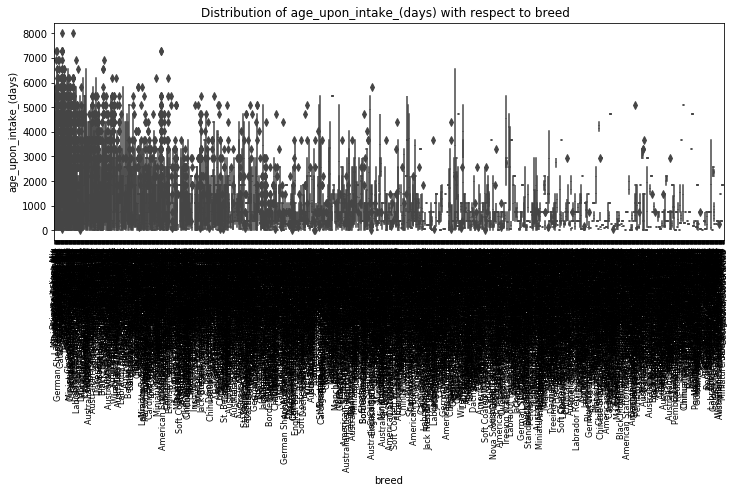

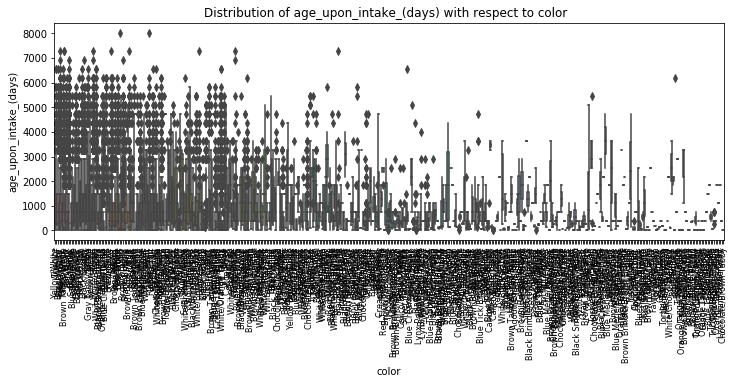

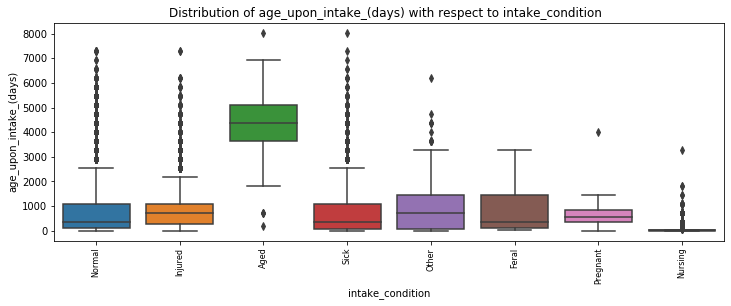

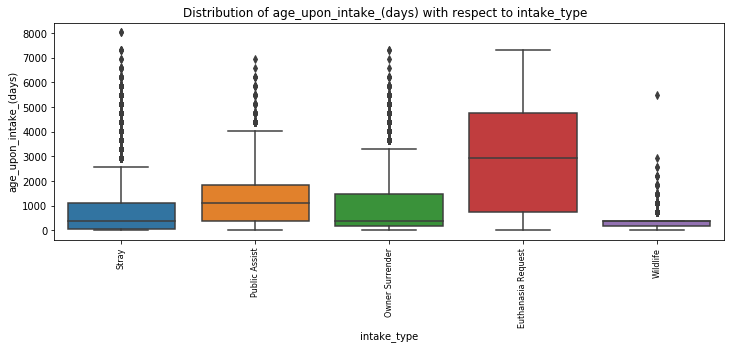

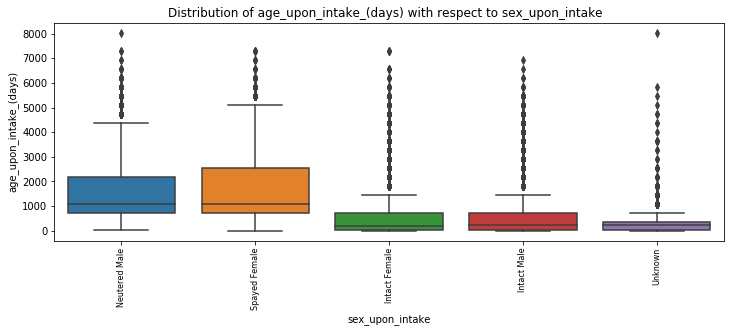

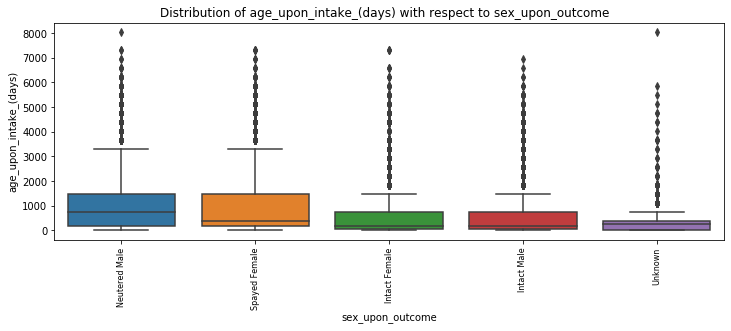

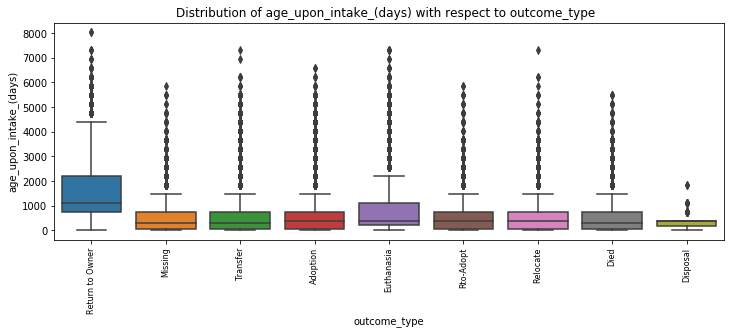

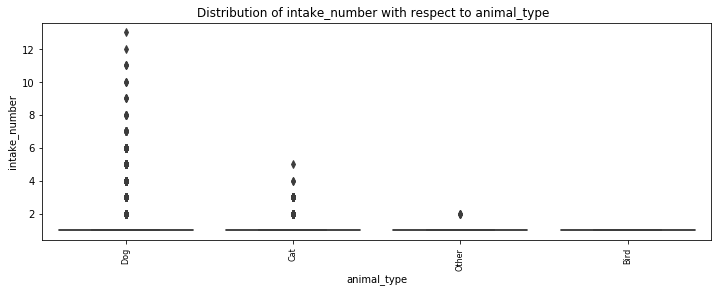

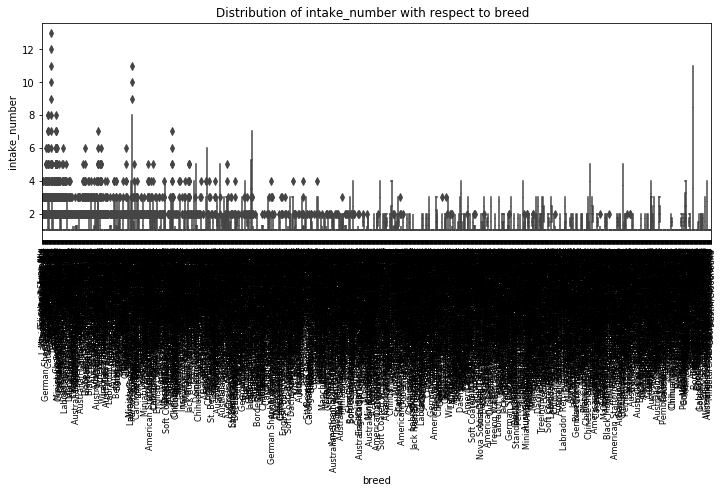

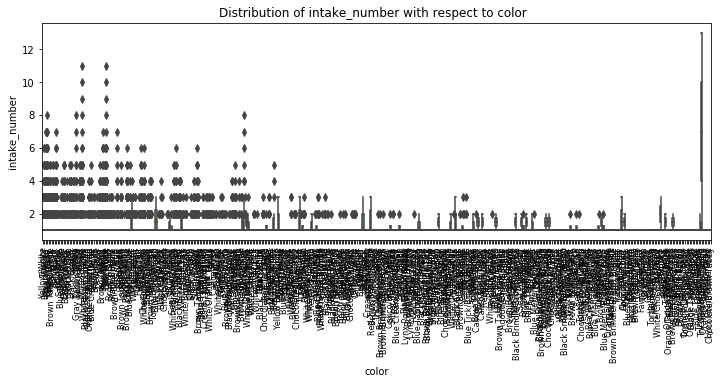

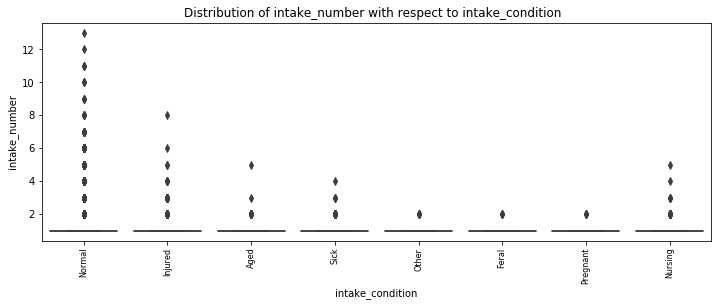

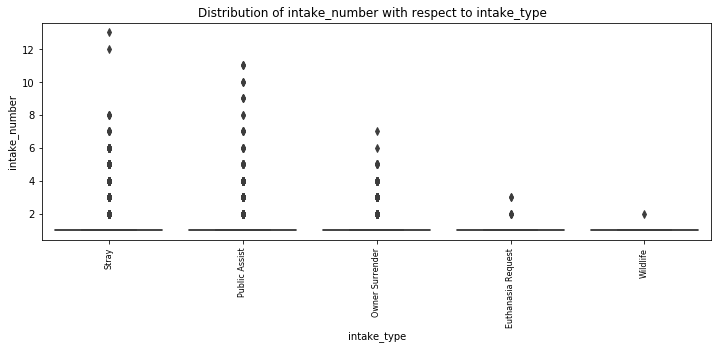

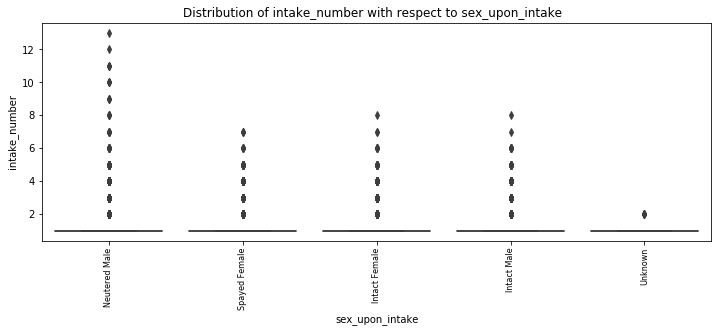

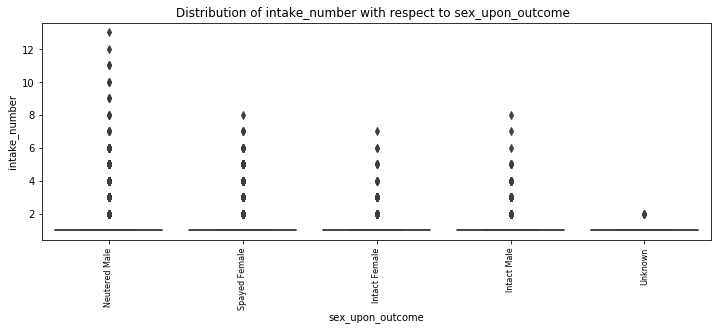

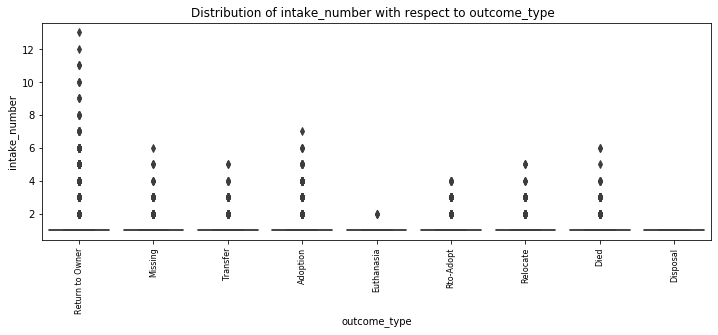

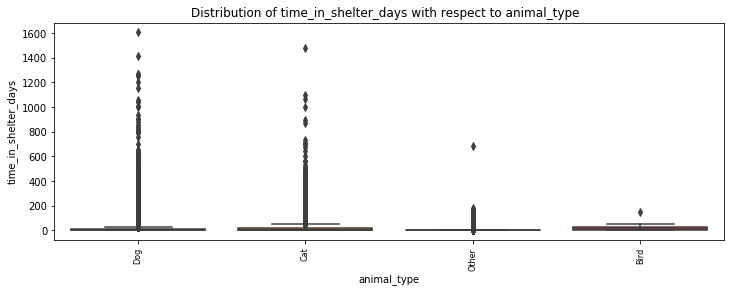

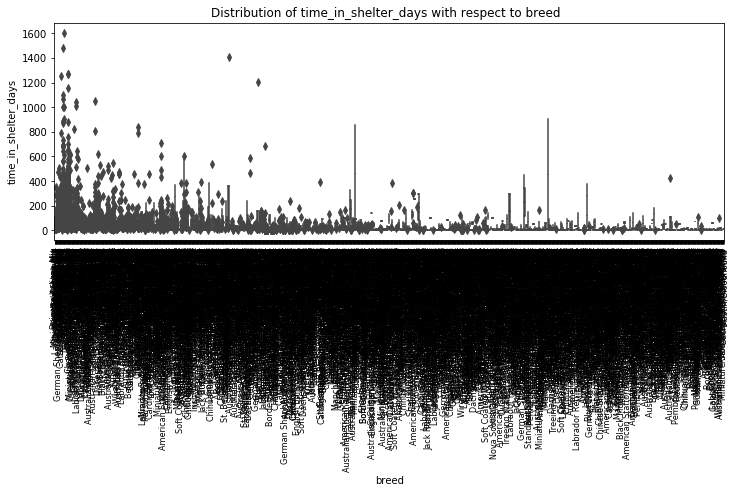

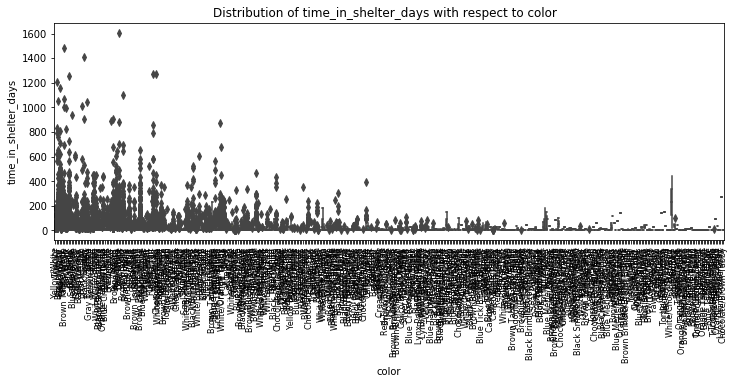

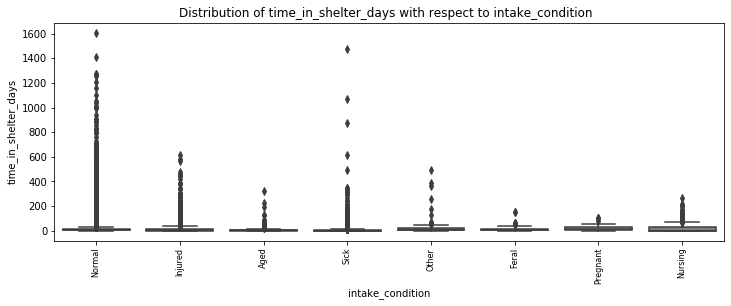

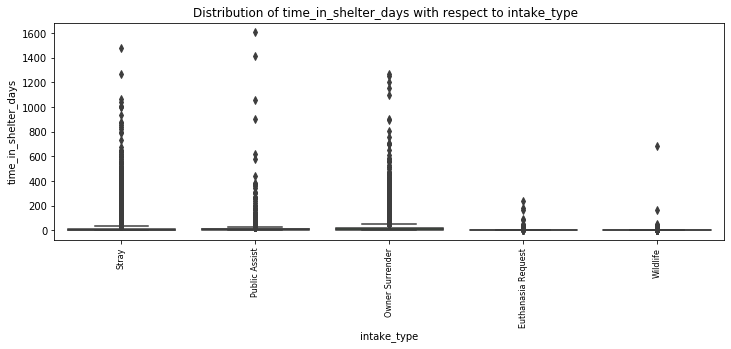

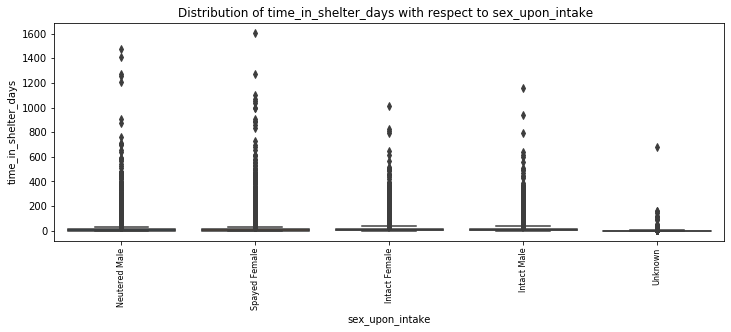

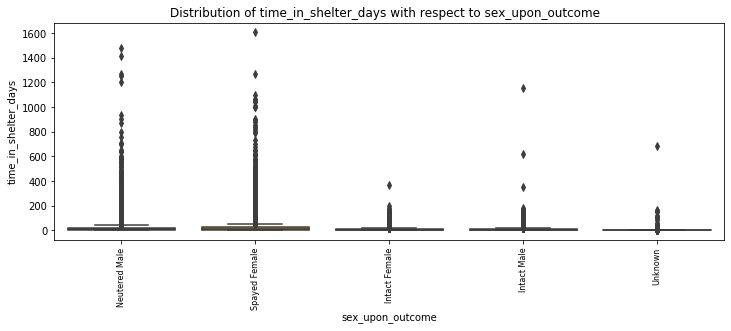

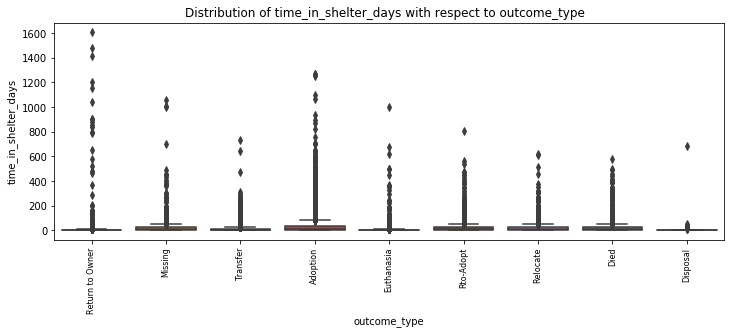

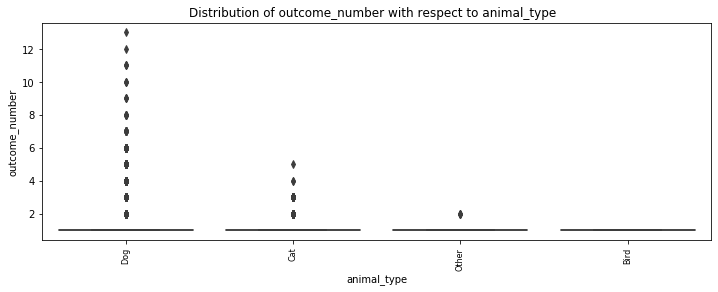

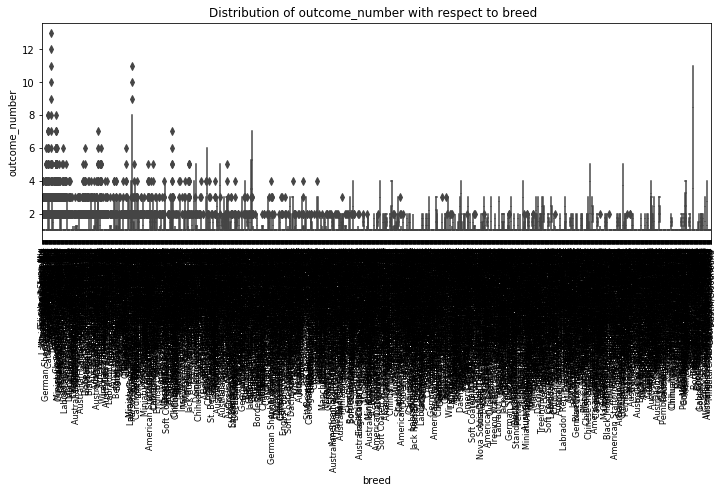

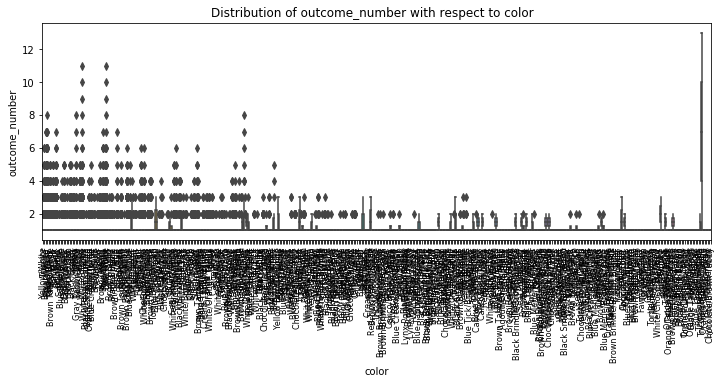

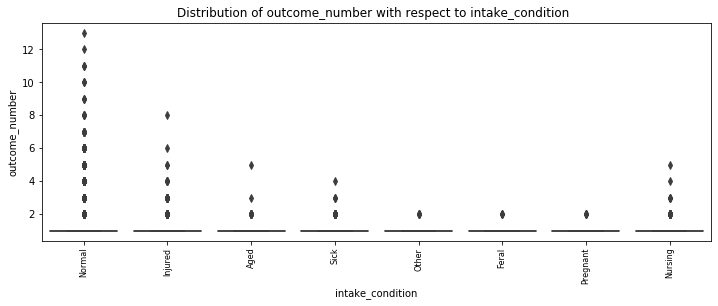

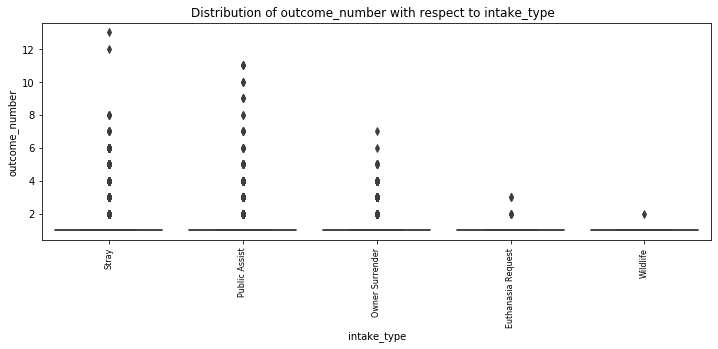

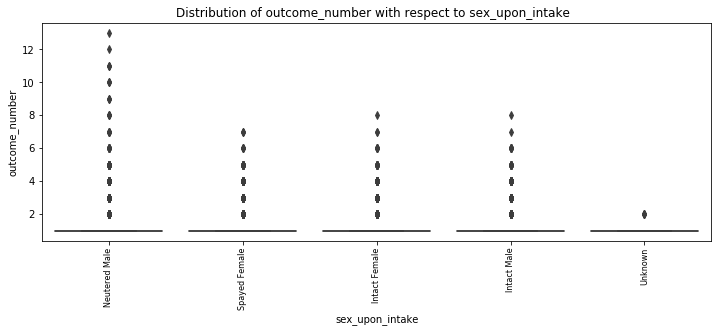

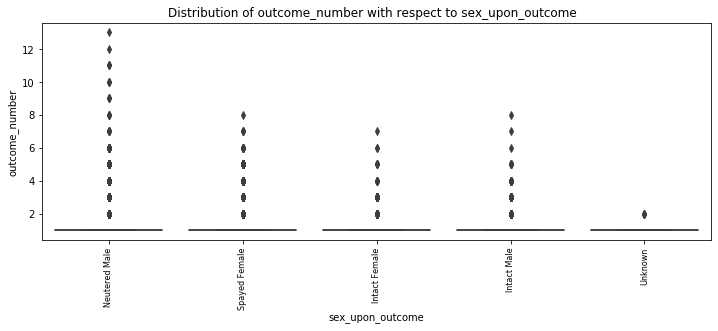

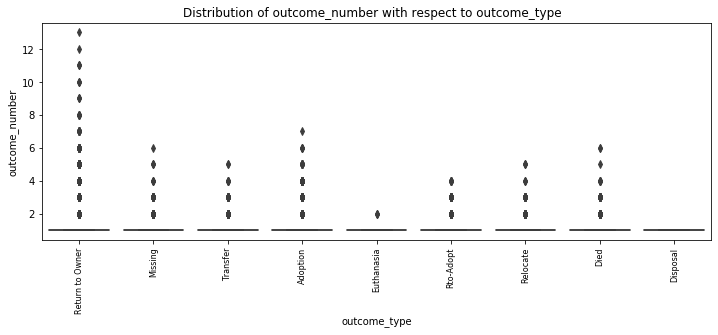

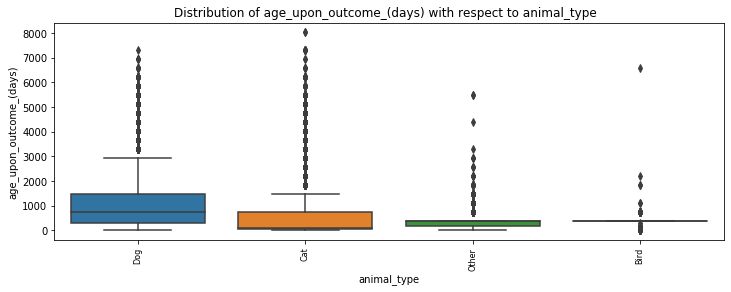

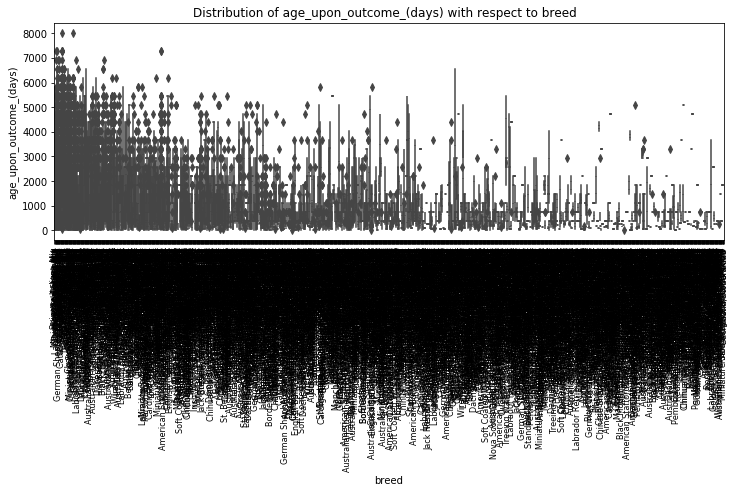

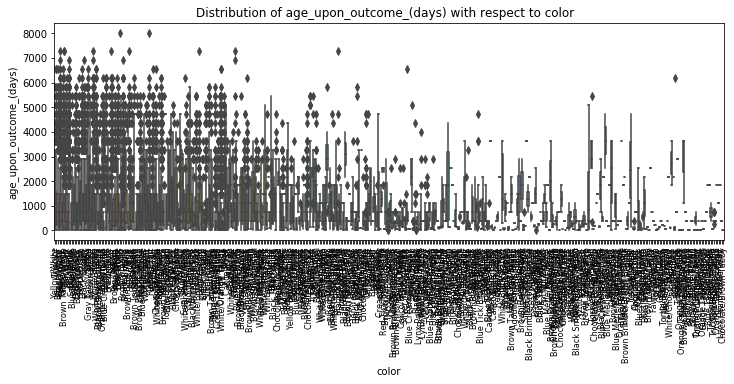

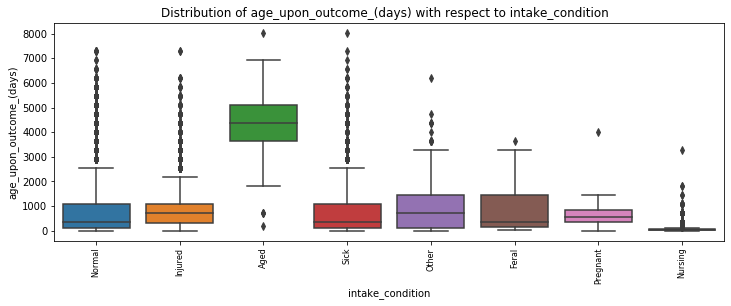

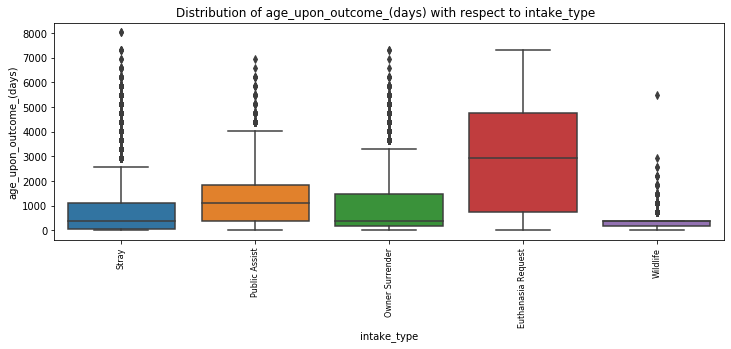

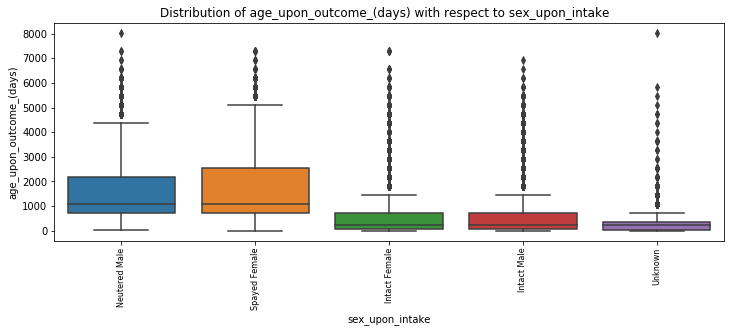

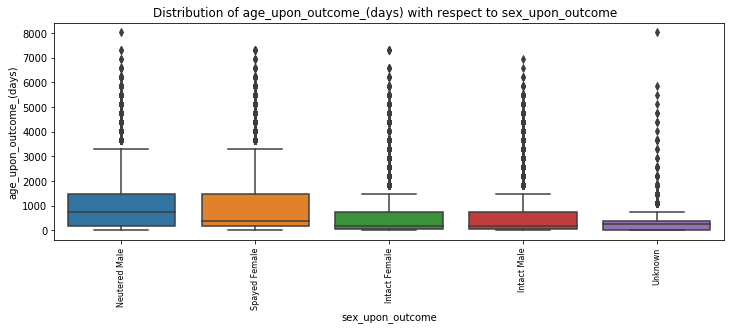

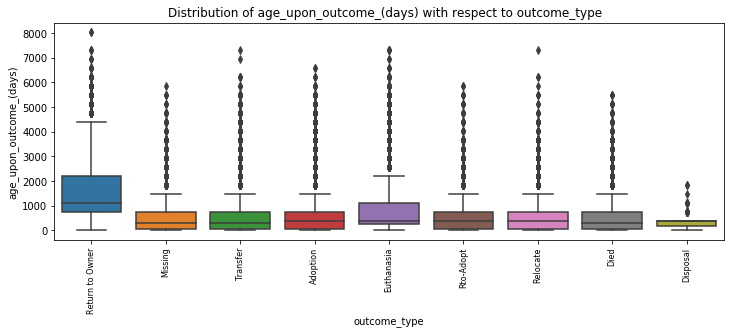

In [100]:
NUM_COLS = ["age_upon_intake_(days)","intake_number","time_in_shelter_days","outcome_number","age_upon_outcome_(days)"]
CAT_COLS = ["animal_type","breed","color","intake_condition","intake_type","sex_upon_intake","sex_upon_outcome","outcome_type"]
for num in NUM_COLS:
    for cat in CAT_COLS:
        plot_box(num,cat," ",train_df,3)

In [102]:
train_df.breed.nunique()

1847

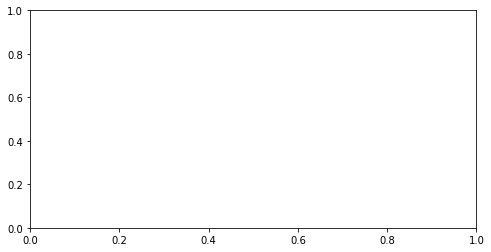

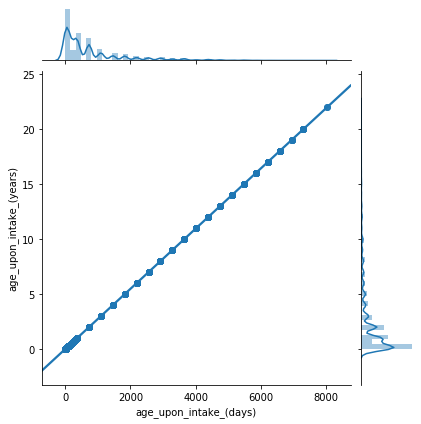

In [91]:
plot_regplot("age_upon_intake_(days)","age_upon_intake_(years)","days_vs_yrs",train_df,2)